In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn 
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

In [12]:
df3 = pd.read_csv("./data/PNJ.csv")
df3['Date/Time'] = pd.to_datetime(df3['Date/Time'])
df3.drop(columns=['Open Interest'], inplace=True)
df3

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146
...,...,...,...,...,...,...,...
125304,PNJ,2020-12-22 14:22:00,78.20,78.20,78.20,78.20,5000
125305,PNJ,2020-12-22 14:23:00,78.20,78.20,78.20,78.20,1700
125306,PNJ,2020-12-22 14:24:00,78.20,78.20,78.20,78.20,870
125307,PNJ,2020-12-22 14:25:00,78.10,78.10,78.10,78.10,13000


In [13]:
df3 = df3[['Date/Time', 'Close']]
df3

,Date/Time,Close
0,2018-02-28 09:15:00,78.99
1,2018-02-28 09:16:00,78.94
2,2018-02-28 09:19:00,78.14
3,2018-02-28 09:20:00,78.14
4,2018-02-28 09:21:00,78.14
...,...,...
125304,2020-12-22 14:22:00,78.20
125305,2020-12-22 14:23:00,78.20
125306,2020-12-22 14:24:00,78.20
125307,2020-12-22 14:25:00,78.10


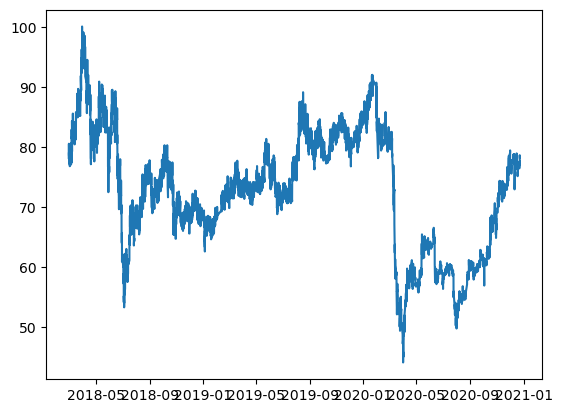

In [14]:
plt.plot(df3['Date/Time'], df3['Close'])

In [17]:
# See previous
from copy import deepcopy as dc 
def prepare_dataframe_from_lstm(df3, n_steps):
    df3 = dc(df3)
    df3.set_index('Date/Time', inplace=True)
    
    for i in range (1, n_steps + 1):
        df3[f'Close(t-{i})'] = df3['Close'].shift(i)
    df3.dropna(inplace=True)
    return df3


lookback = 10
shifted_df = prepare_dataframe_from_lstm(df3, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date/Time,,,,,,,,,,,
2018-02-28 09:27:00,78.75,78.75,78.75,78.14,78.14,78.09,78.14,78.14,78.14,78.94,78.99
2018-02-28 09:28:00,78.85,78.75,78.75,78.75,78.14,78.14,78.09,78.14,78.14,78.14,78.94
2018-02-28 09:29:00,79.93,78.85,78.75,78.75,78.75,78.14,78.14,78.09,78.14,78.14,78.14
2018-02-28 09:32:00,78.85,79.93,78.85,78.75,78.75,78.75,78.14,78.14,78.09,78.14,78.14
2018-02-28 09:33:00,78.89,78.85,79.93,78.85,78.75,78.75,78.75,78.14,78.14,78.09,78.14
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22 14:22:00,78.20,78.30,78.30,78.20,78.20,78.20,78.20,78.20,78.20,78.30,78.20
2020-12-22 14:23:00,78.20,78.20,78.30,78.30,78.20,78.20,78.20,78.20,78.20,78.20,78.30
2020-12-22 14:24:00,78.20,78.20,78.20,78.30,78.30,78.20,78.20,78.20,78.20,78.20,78.20


In [19]:
# Convert to numpy and scaler
shifted_df_as_np = shifted_df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[0.23563013, 0.23563013, 0.23563013, ..., 0.2138522 , 0.24241342,
        0.2441985 ],
       [0.23920029, 0.23563013, 0.23563013, ..., 0.2138522 , 0.2138522 ,
        0.24241342],
       [0.27775794, 0.23920029, 0.23563013, ..., 0.2138522 , 0.2138522 ,
        0.2138522 ],
       ...,
       [0.21599429, 0.21599429, 0.21599429, ..., 0.21599429, 0.21599429,
        0.21599429],
       [0.21242413, 0.21599429, 0.21599429, ..., 0.21599429, 0.21599429,
        0.21599429],
       [0.21956444, 0.21242413, 0.21599429, ..., 0.21599429, 0.21599429,
        0.21599429]])

In [25]:
#Split data X, Y and revere
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X = dc(np.flip(X, axis=1))
X.shape

(125299, 10)

In [32]:
# Split data for training and validation and conver to tensor
split_index = int(len(X) * 0.80)
X_train = X[:split_index]
X_train = X_train.reshape((-1, lookback, 1))
X_train = torch.tensor(X_train).float()

y_train = y[:split_index]
y_train = y_train.reshape((-1, 1))
y_train = torch.tensor(y_train).float()

X_test = X[:split_index]
X_test = X_test.reshape((-1, lookback, 1))
X_test = torch.tensor(X_test).float()

y_test = y[:split_index]
y_test = y_test.reshape((-1, 1))
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([100239, 10, 1]),
 torch.Size([100239, 10, 1]),
 torch.Size([100239, 1]),
 torch.Size([100239, 1]))

In [49]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X 
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    


train_dataset = TimeSeriesDataset(X_train, y_train)
validation_dataset = TimeSeriesDataset(X_test, y_test)

In [34]:
device ='cpu'

In [35]:
#Config
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    break
    

In [36]:
#Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.lstm = nn.LSTM(input_size, hidden_size, layers, batch_first=True)   
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [37]:
# Setup train
model = LSTM(1, 4, 1)
learning_rate = 0.01
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
# Train 
def train(model, criterion, train_loader, validation_loader, optimizer, epochs):
    i = 0
    loss_accuracy = {'training_loss':[], 'test_accuracy':[]}  
    
    for epoch in range(epochs):
        for i,(x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_accuracy['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            yhat = model(x)
            _, label = torch.max(yhat, 1)
            correct += (label==y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        loss_accuracy['validation_accuracy'].append(accuracy)
        
    return loss_accuracy

In [39]:
MSE = train(model, criterion, train_loader, validation_loader, optimizer, num_epochs)

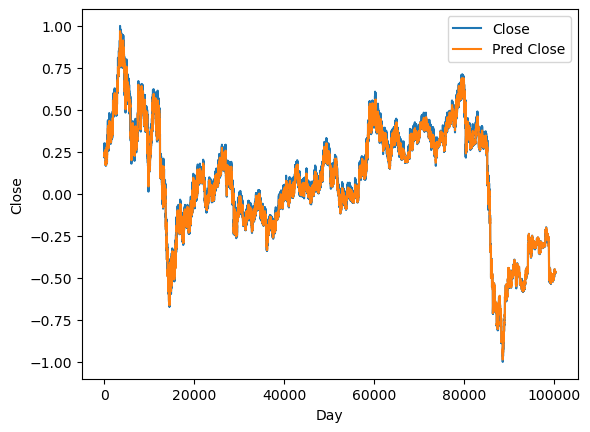

In [42]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Close')
plt.plot(predicted, label='Pred Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [43]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([78.44437468, 78.5210076 , 78.60229098, ..., 59.03554526,
       59.08550749, 59.05975338])

In [44]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([78.7499998 , 78.84999982, 79.92999997, ..., 59.09999982,
       59.00000021, 59.00000021])

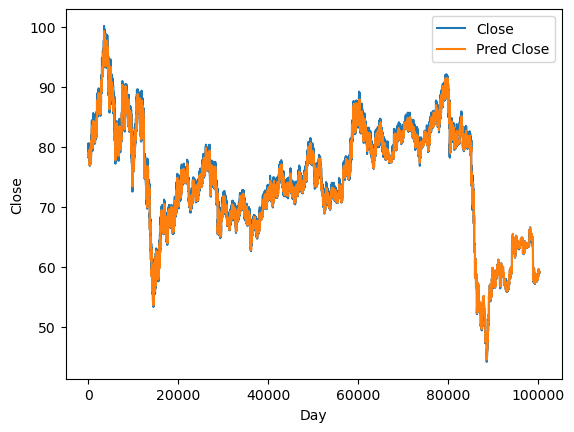

In [45]:
plt.plot(new_y_train, label='Close')
plt.plot(train_predictions, label='Pred Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [46]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([78.44437468, 78.5210076 , 78.60229098, ..., 59.03554359,
       59.08550749, 59.05975338])

In [47]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([78.7499998 , 78.84999982, 79.92999997, ..., 59.09999982,
       59.00000021, 59.00000021])

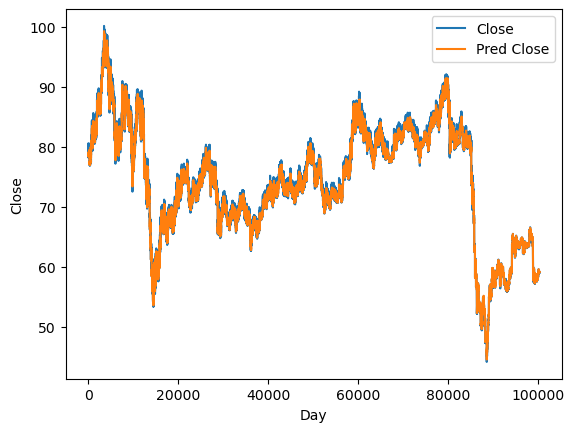

In [48]:
plt.plot(new_y_test, label='Close')
plt.plot(test_predictions, label='Pred Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()